In [85]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [86]:
df = pd.read_csv("Dummy Data HSS.csv")
print(df.head())
print(df.shape)

     TV      Radio  Social Media Influencer       Sales
0  16.0   6.566231      2.907983       Mega   54.732757
1  13.0   9.237765      2.409567       Mega   46.677897
2  41.0  15.886446      2.913410       Mega  150.177829
3  83.0  30.020028      6.922304       Mega  298.246340
4  15.0   8.437408      1.405998      Micro   56.594181
(4572, 5)


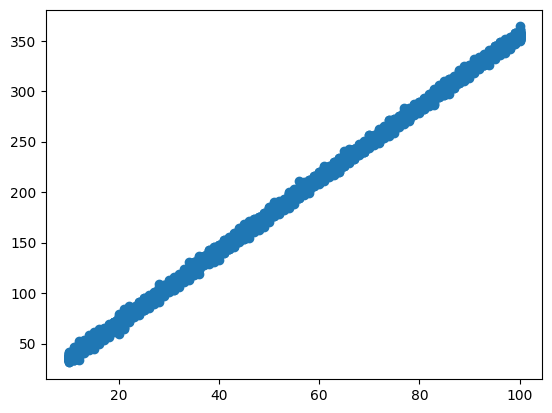

In [87]:
plt.scatter(df.TV, df.Sales)
plt.show()

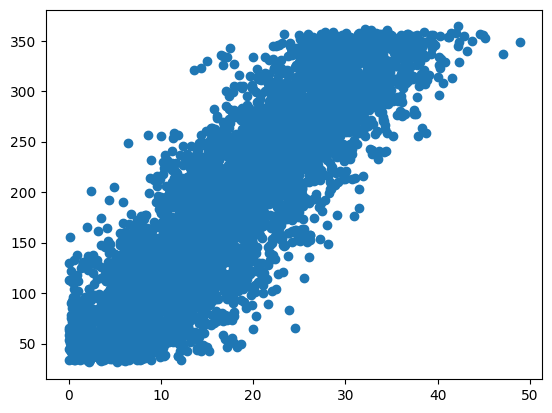

In [88]:
plt.scatter(df.Radio, df.Sales)
plt.show()

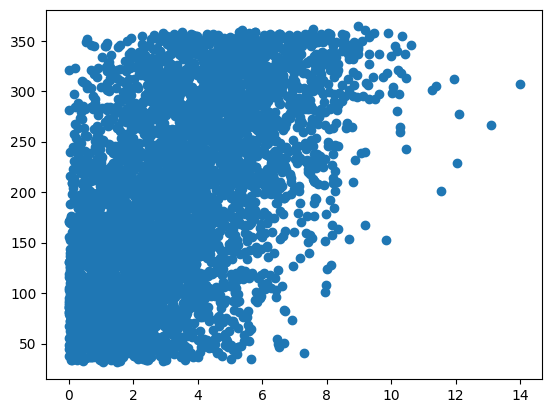

In [89]:
plt.scatter(df["Social Media"], df.Sales)
plt.show()

In [90]:
influencers = df.Influencer.unique()
print(influencers)
mapping = {influencers[i]: i for i in range(len(influencers))}
print(mapping)

print(df.groupby("Influencer")["Sales"].std())
print(df.groupby("Influencer")["Sales"].mean())

['Mega' 'Micro' 'Nano' 'Macro']
{'Mega': 0, 'Micro': 1, 'Nano': 2, 'Macro': 3}
Influencer
Macro    92.574044
Mega     92.307262
Micro    94.298071
Nano     93.377932
Name: Sales, dtype: float64
Influencer
Macro    195.613601
Mega     190.593666
Micro    191.809095
Nano     191.934304
Name: Sales, dtype: float64


Influencers type seems to have negligible effect on sales, since distribution is same

In [91]:
# normalize data
df = df.drop("Influencer", axis=1).dropna()
df = (df - df.mean())/df.std()
print(df.head())

         TV     Radio  Social Media     Sales
0 -1.458073 -1.199523     -0.187898 -1.480120
1 -1.572994 -0.923060     -0.413297 -1.566713
2 -0.500400 -0.235023     -0.185444 -0.454048
3  1.108491  1.227587      1.627507  1.137746
4 -1.496380 -1.005885     -0.867144 -1.460109


In [92]:
X, y = df.drop("Sales", axis=1).to_numpy(), df.Sales.to_numpy(),
train_x, test_x = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
train_y, test_y = y[:int(0.8*len(y))], y[int(0.8*len(y)):]
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(3636, 3) (910, 3) (3636,) (910,)


In [93]:
class LinearRegression:
    def __init__(self, params):
      # Initializing weights and biases. A linear regressor uses one weight and
      # one bias for each distinct feature
        self.weights = np.random.normal(size=params)
        self.bias = np.random.random()*5
        self.loss_tape = []
        self.loss = 0

    # Loss function
    def mse_loss(self, y_pred: np.array, y_true: np.array):
        self.loss = np.mean((y_pred - y_true)**2)

    # Prediction function
    def predict(self, x_input):
        return np.sum(self.weights * x_input, axis=1) + self.bias

    # Critical step to training: updating the weights after training each batch
    # At each iteration, the model predicts the outputs of a batch, calculates the
    # loss derivative, and then 'goes down the slope' in the direction that
    # minimzes the loss
    #
    # Function appears complicated due to the need to ensure proper shapes for
    # every numpy array involved
    def update(self, x_input: np.array, y_pred, y_true, batch_size, lr):
        weight_slope_matrix = 2*(y_pred-y_true)*(x_input.transpose())
        weight_slope_matrix = np.sum(weight_slope_matrix, axis=1)/batch_size
        bias_slope = np.sum(2*(y_pred-y_true))/batch_size

        # print(weight_slope_matrix)
        # The above two steps calculate derivative of the weight and bias numerically
        # However, we don't calculate the slope for EACH sample being used.
        # Rather, we take a batch of samples, calculate their slopes, and then
        # Update everything based on the average calculated slope
        # This is why we divide by the batch size. This provides better
        # gradient descent
        self.weights -= weight_slope_matrix*lr
        self.bias -= bias_slope * lr

    # Epochs is number of times to loop over entire DS
    # Batch size is number of sample points we use to make one step
    # Learning rate (lr) is how far each step down the slope is
    def fit(self, x_input, y_true, epochs:int, batch_size:int, lr:float):
        # Just the training loop which goes through all the batches iteratively
        # updating at each step, and recording the loss for visualization purposes
        for i in range(epochs):
            indices = list(np.random.permutation(range(len(x_input))))
            batch_indices = np.array([indices[batch_size*k: batch_size*(k+1)] for k in range(len(x_input)//batch_size)])
            batches_x = x_input[batch_indices]
            batches_y = y_true[batch_indices]
            epoch_loss = []

            for j in range(len(batches_x)):
                y_pred = self.predict(batches_x[j])
                self.mse_loss(y_pred, batches_y[j])
                self.update(batches_x[j], y_pred, batches_y[j], batch_size, lr)
                epoch_loss.append(self.loss)

            self.loss_tape.append(sum(epoch_loss)/len(epoch_loss))

        # The final result of a linear regressor is just its weights and biases
        # as those are enuf to make future predictions
        return self.weights, self.bias, self.loss_tape

    # Function to shorthand validation
    def test(self, x_validation, y_validation):
        predictions = self.predict(x_validation)
        self.mse_loss(predictions, y_validation)
        return self.loss

In [94]:
print(train_x, train_y)

[[-1.45807306 -1.19952302 -0.18789795]
 [-1.57299383 -0.92306001 -0.41329747]
 [-0.50039998 -0.23502288 -0.18544351]
 ...
 [-0.27055844 -0.54252943 -0.67568977]
 [-0.88346921 -0.75906508 -1.11509478]
 [ 0.38065925  0.43234736 -1.30641856]] [-1.48012    -1.5667129  -0.45404817 ... -0.21001189 -0.91482404
  0.35897343]


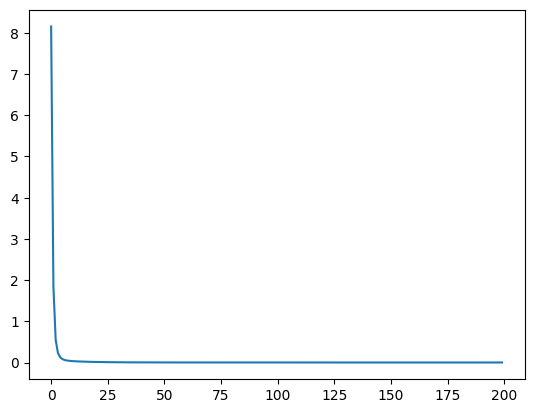

In [101]:
model = LinearRegression(3)
_, __, loss_tape = model.fit(train_x, train_y, epochs=200, batch_size=200, lr=0.01)
plt.plot(range(len(loss_tape)), loss_tape)
plt.show()

In [96]:
print(f"Validation Loss: {model.test(test_x, test_y)}")

Validation Loss: 0.24269974890786256


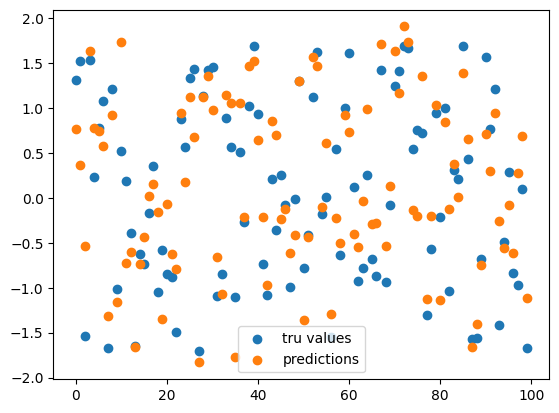

In [97]:
test_predictions = model.predict(test_x)

plt.scatter(range(len(test_y[:100])), test_y[:100], label="tru values")
plt.scatter(range(len(test_y[:100])), test_predictions[:100], label="predictions")
plt.legend()
plt.show()

In [102]:
# R2 score
print(1-np.sum((test_y-test_predictions)**2)/np.sum((test_y-np.mean(test_y))**2))

0.7542115491963262
